In [1]:
#!/usr/bin/env python
import numpy as np
from slsim.Deflectors.light2mass import get_velocity_dispersion
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from slsim.Util.mag2errors import get_errors_Poisson
from uncertainties import unumpy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

This notebook provides an example for getting the stellar velocity dispersion of the deflectors using the light2mass module for slsim. Please down the catalogs 'cosmo_DC2.fits' and 'Bernardi_SDSS_cat.csv' from 'https://github.com/LSST-strong-lensing/data_public' for running this notebook.

The light2mass module in the slsim, has the functionality to get the stellar velocity dispersion of the deflectors
using the LSST broadband magnitudes and the redshift.
Currently, the model works for elliptical galaxies only.

The module has following requirements:
1. It requires 3-band broadband lsst magnitudes and errors, i.e., the 'g', 'r', and 'i' bands. The module runs for multiple targets together, and hence the magnitudes and errors should be passed as 2D arrays with bands along the columns and different targets' magnitudes along the rows.
For now, the code requires the g, r, and i bands data.
2. The source redshift: to be provided as a 1D array of redshifts of different targets.
3. The color conversion coefficients are fixed for converting from the LSST magnitudes to the SDSS magnitudes. The coefficients have been found using the best fit transformation relations for red galaxies. However, if some better conversion relations are know, the coefficients can be replaced accordingly.
4. The code has the availability to use two scaling relations: one is the L-sigma relation for early type galaxies from Choi et al 2007, which is based on stellar velocity dispersion using spectroscopic measurements, and another is to use the L-sigma relation from Parker et al 2007, which is based on the weak lensing measurements. The user has the freedom to choose which scaling relations he/she wants to apply.

NOTE: The module currently has following limitations and we are working on improving them.
1.  Currently, the multi-band LSST magnitudes are used to get the SDSS magnitudes and hence the K-correction on the SDSS filters using Blanton's kcorrect module for galaxies, but we are testing a direct way to perform K-correction on LSST filters, and accordingly the code will be further improved and simplified after implementing those corrections.
2. The velocity dispersion measurements using spectroscopy based relations from Choi et al, are precise for low redshift early type galaxies only, and shows a large scatter for high redshift galaxies. This issue also, is being checked.

Pre-requisites:
1. The light2mass module uses the the Blanton's kcorrect module.
Please install it before using.
https://kcorrect.readthedocs.io/en/5.1.2/install.html

2. Also, install the python module 'uncertainities' for error propogation.
https://pypi.org/project/uncertainties/

3. Other than that, it uses some standard python modules like, numpy, astropy, etc.

In [2]:
# Please download the COSMO DC2 catalog from 'https://github.com/LSST-strong-lensing/data_public'
# Using the COSMO DC2 catalog
DC2_table = Table.read("cosmo_DC2.fits", format="fits")
DC2_table = DC2_table[DC2_table["redshift"] < 2.0]
# If you want to provide higher redshift sources, change the redshift_range in the kcorr_sdss function in k_correction.py


# Please provide the broadband filters for which you have the magnitude measurements.
available_bands = ["g", "r", "i"]

"""
Note: Please provide the three bands data, i.e., the g, r, and i bands.
The three bands are required to perform the k-correction in the SDSS bands, after transforming the lsst 
mags to SDSS mags. If somehow, we can perform k-correction in the LSST bands, we will need only the two g and r bands data.
"""

lsst_mags = np.array(
    [
        DC2_table["mag_true_g_lsst"],
        DC2_table["mag_true_r_lsst"],
        DC2_table["mag_true_i_lsst"],
    ]
).T

# define the LSST zeropoint and exposure time (in secs) for g, r, and i bands.
zeropoint_g, exptime_g = 28.51, 15
zeropoint_r, exptime_r = 28.36, 15
zeropoint_i, exptime_i = 28.17, 15

# Since the mock catalogs donot contain the magnitude errors, we provide a very rough estimate of the error asssuming only the
# statistical error due to Poisson noise in the counts. For better results, use a sample with known magnitude errors.


lsst_errs = np.array(
    [
        get_errors_Poisson(DC2_table["mag_true_g_lsst"], zeropoint_g, exptime_g),
        get_errors_Poisson(DC2_table["mag_true_r_lsst"], zeropoint_r, exptime_r),
        get_errors_Poisson(DC2_table["mag_true_i_lsst"], zeropoint_i, exptime_i),
    ]
).T
redshifts = DC2_table["redshift"].data

To get the velocity dispersion using scaling relations derived from spectroscopic measurments (Choi et al 2007)

In [3]:
vdisp = get_velocity_dispersion(
    deflector_type="elliptical",
    lsst_mags=lsst_mags,
    lsst_errs=lsst_errs,
    redshift=redshifts,
    cosmo=cosmo,
    bands=available_bands,
    c1=0.01011,
    c2=0.01920,
    c3=0.05162,
    c4=-0.00032,
    c5=0.06555,
    c6=-0.02949,
    c7=0.00003,
    c8=0.04040,
    c9=-0.00892,
    c10=-0.03068,
    c11=-0.21527,
    c12=0.09394,
    scaling_relation="spectroscopic",
)

In [4]:
print(
    "Velocity dispersions from spectroscopic measurements based relations, are: \n",
    vdisp,
)

# The nominal values and the errors can be retrieved as follows:
# print('Nominal values are: ',unumpy.nominal_values(vdisp))
# print('Uncertainities are: ',unumpy.std_devs(vdisp))

Velocity dispersions from spectroscopic measurements based relations, are: 
 [8.42920235188833+/-0.3385725853731657
 18.168803789607505+/-0.7128635917832368
 59.28435827585998+/-1.9071643503789089
 10.617018204566365+/-0.6683835374169985
 9.069244752721303+/-0.6993901745714806
 33.52396134584704+/-1.2920561192906364
 10.600610435554037+/-0.8690138702941498
 138.41299261131564+/-4.410222532408445
 10.263400843561747+/-0.9020740457979588
 3.197495364509874+/-1.0628665555864305
 76.13708284378836+/-2.734189993382395
 15.545344317535516+/-1.0153994647874434
 6.544384038103669+/-0.9881263368145845
 6.207915243167802+/-1.0021114932892206
 118.40341518320523+/-3.8927197280873678
 41.56010382485908+/-2.0233076855230125
 44.33080550708283+/-2.2197045985020045
 48.48013244287241+/-1.9356578450300672
 8.010018152565271+/-1.0832208881694059
 8.030169328230294+/-1.0940918699692026
 4.931276572326502+/-1.1180541156854764
 11.285608586843903+/-1.036161608776587
 10.896367546954354+/-1.044210443534385

To get the velocity dispersion using scaling relations derived from weak lensing measurments (Parker et al 2007)

In [5]:
vdisp = get_velocity_dispersion(
    deflector_type="elliptical",
    lsst_mags=lsst_mags,
    lsst_errs=lsst_errs,
    redshift=redshifts,
    cosmo=cosmo,
    bands=available_bands,
    c1=0.01011,
    c2=0.01920,
    c3=0.05162,
    c4=-0.00032,
    c5=0.06555,
    c6=-0.02949,
    c7=0.00003,
    c8=0.04040,
    c9=-0.00892,
    c10=-0.03068,
    c11=-0.21527,
    c12=0.09394,
    scaling_relation="weak-lensing",
)

In [6]:
print(
    "Velocity dispersions from weak-lensing measurements based relations, are: \n",
    vdisp,
)
# print('Nominal values are: ',unumpy.nominal_values(vdisp))
# print('Uncertainities are: ',unumpy.std_devs(vdisp))
# vdisp_wl = unumpy.nominal_values(vdisp)

Velocity dispersions from weak-lensing measurements based relations, are: 
 [13.387027424007767+/-1.0830641817701159
 22.965690109137515+/-1.858643750750225
 63.6854055310869+/-5.116434149222039 17.10809526052398+/-1.42604058298006
 19.411868284241272+/-1.6163449062840807
 34.91379456647167+/-2.820794963496428
 19.334142923287583+/-1.6380916806242183
 133.81671883962457+/-16.964639335624515
 18.89024359709237+/-1.6142916584659028
 8.519473069615556+/-1.1279990146334957
 78.75527787931124+/-6.334063159783412
 24.90857926180475+/-2.0701897965255154
 15.213255252603899+/-1.405936126093785
 14.36201597996958+/-1.357813911726801
 120.92467027569158+/-15.332215612027797
 40.224605553334+/-3.264911489496284
 44.917512457079376+/-3.6446589683392494
 46.15951435263578+/-3.7292764860129526
 17.83853147045121+/-1.6052856517219154
 17.271685751420236+/-1.5685749508133588
 11.005054195358897+/-1.2293409260363082
 20.57924616547681+/-1.7663890531174584
 22.68517457514295+/-1.9284361648656234
 11.372

Below, we show a test example for applying this module on some known early-type galaxies from the Bernardi et al 2003,
and comparing our measurements with the SDSS velocity dispersion measurements for these galaxies. Note that we donot have
a sample for comparing the weak-lensing based measurements, and we are comparing only the spectroscopy based measurements.
Also, the Choi et al 2007 relations fail at high redshifts and hence currently, we have a limitation that our module works best for 
low redhisft galaxies only.

In [7]:
# Please download the below catalog from 'https://github.com/LSST-strong-lensing/data_public'
data_table = Table.read("Bernardi_SDSS_cat.csv", format="csv")

# Please provide the broadband filters for which you have the magnitude measurements.
available_bands = ["g", "r", "i"]

"""
Note: Please provide the three bands data, i.e., the g, r, and i bands.
The three bands are required to perform the k-correction in the SDSS bands. If somehow,
we can perform k-correction in the LSST bands, we will need only the two g and r bands data.
"""
sdss_mags = np.array([data_table["gmag"], data_table["rmag"], data_table["imag"]]).T
sdss_errs = np.array(
    [data_table["err_gmag"], data_table["err_rmag"], data_table["err_imag"]]
).T
redshifts = data_table["zsp"].data

# To compare the results from the velocity dispersion measurements for Bernardi et al galaxies, from SDSS measurements and
# our measurements using the scaling relations based on spectroscopic measurements.
# Skip this part if you're not testing the Bernardi et al sample.
logVDis, e_logVDis, vdisp_SDSS, vdisp_err_SDSS = (
    data_table["log_vdisp_Bernardi"],
    data_table["errlog_vdisp_Bernardi"],
    data_table["vdisp_SDSS"],
    data_table["vdisp_err_SDSS"],
)
VDis = 10 ** (logVDis)

In [8]:
vdisp = get_velocity_dispersion(
    deflector_type="elliptical",
    lsst_mags=sdss_mags,
    lsst_errs=sdss_errs,
    redshift=redshifts,
    cosmo=cosmo,
    bands=available_bands,
    c1=0,
    c2=0,
    c3=0,
    c4=0,
    c5=0,
    c6=0,
    c7=0,
    c8=0,
    c9=0,
    c10=0,
    c11=0,
    c12=0,
    scaling_relation="spectroscopic",
)

vdisp_spec = unumpy.nominal_values(vdisp)

In [9]:
vdisp = get_velocity_dispersion(
    deflector_type="elliptical",
    lsst_mags=sdss_mags,
    lsst_errs=sdss_errs,
    redshift=redshifts,
    cosmo=cosmo,
    bands=available_bands,
    c1=0,
    c2=0,
    c3=0,
    c4=0,
    c5=0,
    c6=0,
    c7=0,
    c8=0,
    c9=0,
    c10=-0.03068,
    c11=-0.21527,
    c12=0.09394,
    scaling_relation="weak-lensing",
)
vdisp_wl = unumpy.nominal_values(vdisp)

Plot the results obtained by using spectroscopy based relations and compare with SDSS velocity dispersion, for the Bernardi sample.

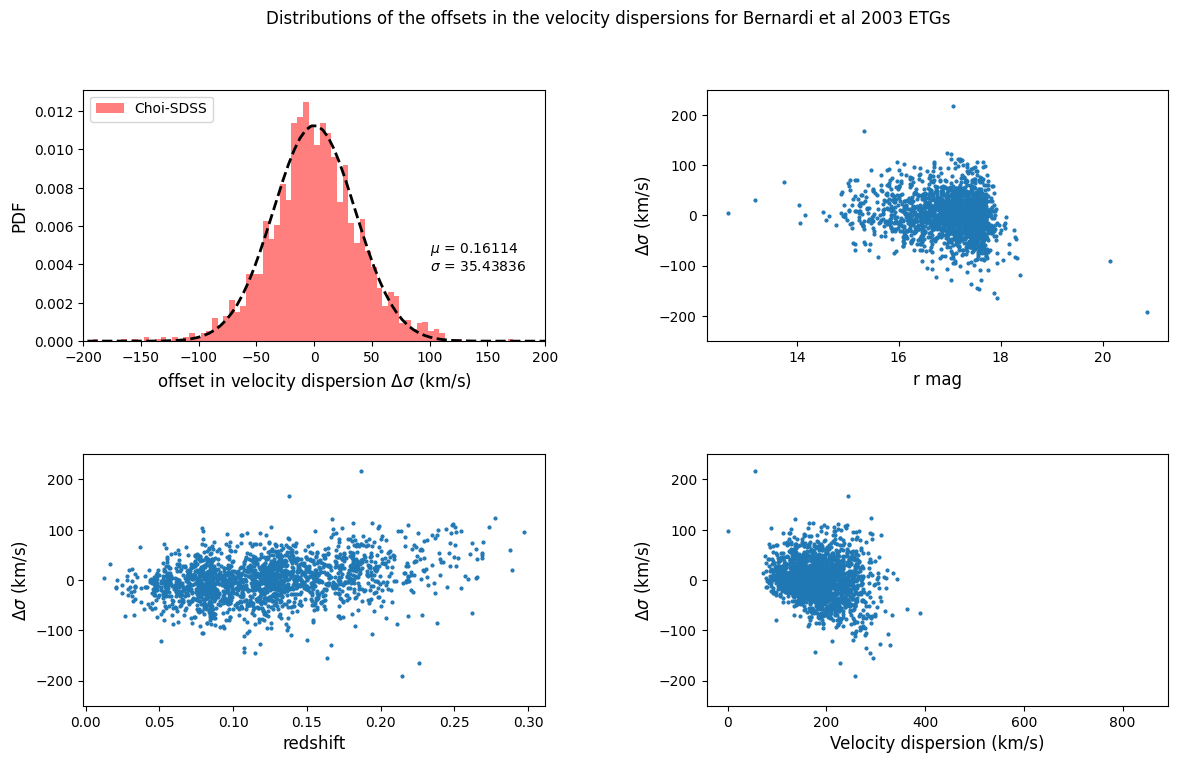

In [10]:
fnt_sz, leg_sz = 12, 10
fig = plt.figure(1, figsize=(14, 8))
plt.subplots_adjust(wspace=0.35, hspace=0.45)
ax1 = plt.subplot(2, 2, 1)
nbins = 200
n1, bins1, patches1 = ax1.hist(
    vdisp_spec - vdisp_SDSS,
    nbins,
    density=True,
    facecolor="red",
    edgecolor="none",
    alpha=0.5,
    label="Choi-SDSS",
)
centers = 0.5 * (bins1[1:] + bins1[:-1])
pars, cov = curve_fit(
    lambda x, mu, sig: norm.pdf(x, loc=mu, scale=sig), centers, n1, p0=[0, 20]
)
ax1.plot(centers, norm.pdf(centers, *pars), "k--", linewidth=2)
ax1.set_xlim(-200, 200)
ax1.text(0.75, 0.35, "$\mu$ = %.5f" % (pars[0]), transform=ax1.transAxes)
ax1.text(0.75, 0.28, "$\sigma$ = %.5f" % (pars[1]), transform=ax1.transAxes)
ax1.legend(loc="upper left")
plt.xlabel(r"offset in velocity dispersion $\Delta \sigma$ (km/s)", fontsize=fnt_sz)
plt.ylabel("PDF", fontsize=fnt_sz)

ax2 = plt.subplot(2, 2, 2)
ax2.scatter(data_table["rmag"].data, vdisp_spec - vdisp_SDSS, s=1, linewidth=2)
ax2.set_ylim(-250, 250)
plt.xlabel("r mag", fontsize=fnt_sz)
plt.ylabel(r"$\Delta \sigma$ (km/s)", fontsize=fnt_sz)

ax2 = plt.subplot(2, 2, 3)
ax2.scatter(data_table["zsp"].data, vdisp_spec - vdisp_SDSS, s=1, linewidth=2)
ax2.set_ylim(-250, 250)
plt.xlabel("redshift", fontsize=fnt_sz)
plt.ylabel(r"$\Delta \sigma$ (km/s)", fontsize=fnt_sz)

ax2 = plt.subplot(2, 2, 4)
ax2.scatter(vdisp_SDSS, vdisp_spec - vdisp_SDSS, s=1, linewidth=2)
ax2.set_ylim(-250, 250)
plt.xlabel("Velocity dispersion (km/s)", fontsize=fnt_sz)
plt.ylabel(r"$\Delta \sigma$ (km/s)", fontsize=fnt_sz)

plt.suptitle(
    "Distributions of the offsets in the velocity dispersions for Bernardi et al 2003 ETGs"
)
plt.show()